In [39]:
import pandas as pd
import numpy as np
from feature_selection import FeatureSelection
from data_enrichment import DataEnrichment
from copy import deepcopy
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from data_overview import DataOverview

In [40]:
de = DataEnrichment()
do = DataOverview()

#### --- Biased data ---
##### Over the following lines we will try to target the problem of biased data with resampling techniques. By that we will try to balance the 0,1 labels amounts.
##### We going to use the follows process 1) resampel and adding nois 2) split our 1 to groups and shuffel the features between the seperate groups. once the groups will build with respect to time from install to previous_policies and once with a respect to k-means output

## Train Test split '

In [41]:
df = pd.read_csv('./data/df_before_encoding.csv', index_col=[0])
train, test  = train_test_split(df, test_size=0.15, random_state=20)

# Resampeling and adding noise: 
##### For continuous features: adding normal noise with mu = 0 and sigma  = feature standard deviation
##### For discrete features: adding noise from discrete uniform distribution {-2,...,2}

In [42]:
number_of_resamples  = train.shape[0] // train.label.sum() -1
train_resampled = de.resample_and_add_noise(df =train,
                                            labeled_col_name = 'label',
                                            n = number_of_resamples ,
                                            resample_on = True)

# Saving for "train and eval" section
train_resampled.to_csv("./data/df_resampled.csv")
print(f'Before resampeling =\n{train.label.value_counts()}')
print(f'\nAfter resampeling \n{train_resampled.label.value_counts()}')

Before resampeling =
False    10298
True       239
Name: label, dtype: int64

After resampeling 
True     10516
False    10298
Name: label, dtype: int64


### Visualization check  -  densities
###### for deeper investigation its recomended to use formal test as Kolmogorov-Smirnov test


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12397 entries, -9.16005e+18_2.49201e+18 to -9.03879e+18_-6.86341e+18
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state                    12397 non-null  object 
 1   product                  12397 non-null  object 
 2   square_ft                12397 non-null  float64
 3   has_fire_alarm           12397 non-null  bool   
 4   has_burglar_alarm        12397 non-null  bool   
 5   portable_electronics     12397 non-null  bool   
 6   coast                    12397 non-null  int64  
 7   fire_housing_proximity   12397 non-null  int64  
 8   previous_policies        12397 non-null  int64  
 9   user_age                 12397 non-null  float64
 10  card_type                12396 non-null  object 
 11  label                    12397 non-null  bool   
 12  number_of_na             12397 non-null  int64  
 13  grouped_postal_code      12397 non-nul

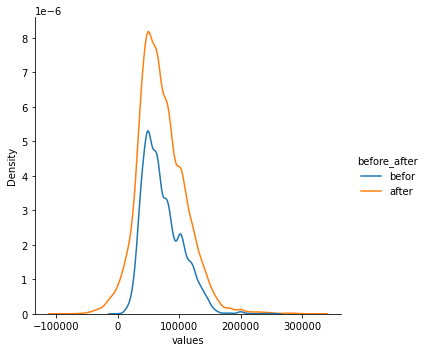

In [44]:
values = train_resampled.median_household_income.tolist() + [i + 0.1 for i in train.median_household_income.tolist()]
before_after = ['befor'] *train.shape[0] + ['after'] *train_resampled.shape[0]
dt = {'values':values,'before_after':before_after}
sns.displot(dt, x="values", hue="before_after", kind="kde")
plt.show()

### --- feature shuffelling --- 

##### Now lets try another technique of creating artificial points (here i influenced a littel by "Genetic algorithms" process). The way we will create new sampels is by shuffeling features between our label-one group. We do that because we assume that the label-one group is shared something in common.But, before that we will try to find sub level-one groups and shuffle the features within these groups. The way we will grouped our label on to sub-group weill split to two: 1) Logic split (time frames) -- 2) unsupervised split (k-means)


### previous_policies

##### Lets try to seperate our label one users by above and below number of policies (Assumption - users with same numner of policies has something in common)

In [45]:
do.value_counts_and_percentage(df = df , column = 'previous_policies')

,count,%
0,9898,0.798419
1,2152,0.173590
2,275,0.022183
3,48,0.003872
4,19,0.001533
5,3,0.000242
7,1,0.000081
6,1,0.000081


In [46]:
# split train for two groups above and equal  0 previous_policies
df = pd.read_csv('./data/df_before_encoding.csv', index_col=[0])
train, test  = train_test_split(df , test_size=0.15, random_state=20)
df_lower = train[(train.previous_policies  == 0) ]
df_upper = train[(train.previous_policies > 0 ) ]


##### resampeling each of the two groups 

In [47]:
number_of_resamples  = df_lower.shape[0] // df_lower.label.sum() -1

resampled_df_lower = de.resample_df(df = df_lower[df_lower.label == 1],
                       number_of_resamples = number_of_resamples )

number_of_resamples  = df_upper.shape[0] // df_upper.label.sum() -1

resampled_df_upper = de.resample_df(df = df_upper[df_upper.label == 1],
                       number_of_resamples = number_of_resamples)

##### Print groups shapes

In [48]:

print(resampled_df_lower.shape,df_lower.shape)
print(resampled_df_upper.shape,df_upper.shape)
print(resampled_df_lower.label.value_counts())
print(resampled_df_upper.label.value_counts())


(8323, 15) (8427, 15)
(2088, 15) (2110, 15)
True    8323
Name: label, dtype: int64
True    2088
Name: label, dtype: int64


##### feature shuffelling 

In [49]:
shuffled_lower = de.shuffle_features(df = resampled_df_lower,
                                     columns_for_shuffeling = resampled_df_lower.columns)

shuffled_upper = de.shuffle_features(df = resampled_df_upper,
                                     columns_for_shuffeling = resampled_df_upper.columns)

#### Making sure shapes didnt chaneged after shuffeling 

In [50]:
assert shuffled_lower.shape == resampled_df_lower.shape 
assert shuffled_upper.shape == resampled_df_upper.shape 
shuffled_lower.equals(resampled_df_lower) , shuffled_upper.equals(resampled_df_upper)

(False, False)

#### Save shuffled data frames 

In [51]:
train_resampled_time_window_shuffled = pd.concat([shuffled_upper,shuffled_lower,train[train.label == 0 ]])
train_resampled_time_window_shuffled.to_csv('./data/train_resampled_previous_policies.csv')
train_resampled_time_window_shuffled.label.value_counts()

True     10411
False    10298
Name: label, dtype: int64

### Feature shuffelling - k-means

#### Above we split our label-one group into two groups cause we believed that users with label-1 and same number policies have something in common.
#### Now, with no past assumptions, let's gives k-means algorithm decide and pick the groups for use.
#### Then, after the help of the k-means, we will shuffle the features of the label-1 users between the separate k-means groups.

In [52]:
df_before_encoding = pd.read_csv('./data/df_before_encoding.csv', index_col=[0])
train, test  = train_test_split(df_before_encoding , test_size=0.15, random_state=20)


###### Isolating the label-1 group

In [53]:
df_tigered = train[train.label == 1 ]


###### Running K-means in order in order to create 3 groups

In [54]:
df_tigered = de.clustering_with_Kmeans(data = df_tigered, cols_to_ignore = [],k_clusters=3)
df_tigered.k_m_label.value_counts()

0    91
1    78
2    70
Name: k_m_label, dtype: int64

###### Split the new groups into 3 dataframes

In [55]:
df_zero = df_tigered[df_tigered.k_m_label == 0 ].drop(columns = 'k_m_label')
df_one  = df_tigered[df_tigered.k_m_label == 1 ].drop(columns = 'k_m_label')
df_two  = df_tigered[df_tigered.k_m_label == 2 ].drop(columns = 'k_m_label')

###### Resample each dataframe


In [56]:
number_of_resamples  = train.shape[0] // train.label.sum() -1

resampled_df_zero = de.resample_df(df = df_zero,
                       number_of_resamples = number_of_resamples )
resampled_df_one = de.resample_df(df = df_one,
                      number_of_resamples = number_of_resamples)
resampled_df_two = de.resample_df(df = df_two,
                       number_of_resamples = number_of_resamples)

In [57]:
print(resampled_df_zero.shape,df_zero.shape)
print(resampled_df_one.shape,df_one.shape)
print(resampled_df_two.shape,df_two.shape)

(4004, 15) (91, 15)
(3432, 15) (78, 15)
(3080, 15) (70, 15)


###### Shuffel feature in each dataframe


In [58]:
shuffled_zero = de.shuffle_features(df = resampled_df_zero,
                                  columns_for_shuffeling = resampled_df_zero.columns)

shuffled_one = de.shuffle_features(df = resampled_df_one,
                                  columns_for_shuffeling = resampled_df_one.columns)

shuffled_two = de.shuffle_features(df = resampled_df_two,
                                  columns_for_shuffeling = resampled_df_two.columns)

In [59]:
assert shuffled_zero.shape == resampled_df_zero.shape 
assert shuffled_one.shape == resampled_df_one.shape 
assert shuffled_two.shape == resampled_df_two.shape 

resampled_df_zero.equals(shuffled_zero) ,resampled_df_one.equals(shuffled_one) , resampled_df_two.equals(shuffled_two)

(False, False, False)

#### Concatenate back and save to csv

In [60]:
train_resampled_k_means_shuffled = pd.concat([shuffled_zero,shuffled_one,shuffled_two,train[train.label == 0 ]])
train_resampled_k_means_shuffled.to_csv('./data/train_resampled_k_means_shuffled.csv')
train_resampled_k_means_shuffled.label.value_counts()

1    10516
0    10298
Name: label, dtype: int64